In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [3]:
name_df=pd.read_csv('ranking_data_sets/name.basics.tsv', sep='\t')
title_df=pd.read_csv('ranking_data_sets/title.ratings.tsv', sep='\t')

In [8]:
len(name_df['primaryName'].unique())

10129329

In [10]:
len(name_df)

13115801

In [11]:
len(title_df)

1380533

In [12]:
name_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0053137,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0054452,tt0049189"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0072562,tt0080455"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0069467,tt0050986,tt0050976"


In [5]:
title_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2008
1,tt0000002,5.7,270
2,tt0000003,6.5,1925
3,tt0000004,5.4,178
4,tt0000005,6.2,2698


In [13]:

known_titles = name_df['knownForTitles'].str.split(',', expand=True).stack().reset_index(level=1, drop=True)
known_titles.name = 'knownForTitle'

expanded_name_df = name_df.drop(columns=['knownForTitles']).join(known_titles)


merged_df = pd.merge(expanded_name_df, title_df, left_on='knownForTitle', right_on='tconst')


print(merged_df.head())


      nconst     primaryName birthYear deathYear  \
0  nm0000001    Fred Astaire      1899      1987   
1  nm0002045   Stanley Donen      1924      2019   
2  nm0006037  Adolph Deutsch      1897      1980   
3  nm0041509  Michel Auclair      1922      1988   
4  nm0042857  Richard Avedon      1923      2004   

                          primaryProfession knownForTitle     tconst  \
0            soundtrack,actor,miscellaneous     tt0050419  tt0050419   
1           director,miscellaneous,producer     tt0050419  tt0050419   
2      composer,music_department,soundtrack     tt0050419  tt0050419   
3                       actor,miscellaneous     tt0050419  tt0050419   
4  miscellaneous,camera_department,director     tt0050419  tt0050419   

   averageRating  numVotes  
0            7.0     32364  
1            7.0     32364  
2            7.0     32364  
3            7.0     32364  
4            7.0     32364  


In [14]:
merged_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitle,tconst,averageRating,numVotes
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous",tt0050419,tt0050419,7.0,32364
1,nm0002045,Stanley Donen,1924,2019,"director,miscellaneous,producer",tt0050419,tt0050419,7.0,32364
2,nm0006037,Adolph Deutsch,1897,1980,"composer,music_department,soundtrack",tt0050419,tt0050419,7.0,32364
3,nm0041509,Michel Auclair,1922,1988,"actor,miscellaneous",tt0050419,tt0050419,7.0,32364
4,nm0042857,Richard Avedon,1923,2004,"miscellaneous,camera_department,director",tt0050419,tt0050419,7.0,32364
...,...,...,...,...,...,...,...,...,...
13695812,nm9993149,June Del Mar,\N,\N,camera_department,tt0137768,tt0137768,7.6,108
13695813,nm9993259,Peter Aufreiter,\N,\N,NaN,tt8724014,tt8724014,7.4,8
13695814,nm9993260,Anna Lisa Genovese,\N,\N,NaN,tt8724014,tt8724014,7.4,8
13695815,nm9993261,Tom Henry,\N,\N,NaN,tt8724014,tt8724014,7.4,8


In [15]:
import pandas as pd

aggregated_df = merged_df.groupby(['tconst', 'averageRating', 'numVotes'])['primaryName'].apply(list).reset_index()


aggregated_df.rename(columns={'primaryName': 'credited_actors'}, inplace=True)


print(aggregated_df)


           tconst  averageRating  numVotes  \
0       tt0000001            5.7      2008   
1       tt0000003            6.5      1925   
2       tt0000004            5.4       178   
3       tt0000005            6.2      2698   
4       tt0000007            5.4       842   
...           ...            ...       ...   
620970  tt9916428            3.5        17   
620971  tt9916460            9.4        18   
620972  tt9916538            8.6         7   
620973  tt9916544            6.8        70   
620974  tt9916730            7.6        11   

                                          credited_actors  
0                                            [Carmencita]  
1       [Émile Reynaud, Gaston Paulin, Julien Pappé, T...  
2                                         [Gaston Paulin]  
3                              [Charles Kayser, John Ott]  
4                                        [Peter Courtney]  
...                                                   ...  
620970                    [

In [16]:
aggregated_df.head()

,tconst,averageRating,numVotes,credited_actors
0,tt0000001,5.7,2008,[Carmencita]
1,tt0000003,6.5,1925,"[Émile Reynaud, Gaston Paulin, Julien Pappé, T..."
2,tt0000004,5.4,178,[Gaston Paulin]
3,tt0000005,6.2,2698,"[Charles Kayser, John Ott]"
4,tt0000007,5.4,842,[Peter Courtney]


In [18]:
unique_tuples = set(tuple(x) for x in aggregated_df['credited_actors'])


unique_count = len(unique_tuples)

print(unique_count)


615884


In [19]:
title_basics_df=pd.read_csv('ranking_data_sets/title.basics.tsv', sep='\t')

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_66504/1245773564.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics_df=pd.read_csv('ranking_data_sets/title.basics.tsv', sep='\t')


In [20]:
title_basics_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10415893,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10415894,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10415895,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10415896,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [21]:
title_basics_df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [25]:
basics_df_selected=title_basics_df[['tconst','titleType','isAdult','runtimeMinutes']]

In [27]:
basics_df_selected.head()

,tconst,titleType,isAdult,runtimeMinutes
0,tt0000001,short,0,1
1,tt0000002,short,0,5
2,tt0000003,short,0,4
3,tt0000004,short,0,12
4,tt0000005,short,0,1


In [23]:
title_eps_df=pd.read_csv('ranking_data_sets/title.episode.tsv', sep='\t')

In [28]:
eps_df_selected=title_eps_df[['tconst','seasonNumber','episodeNumber']]
eps_df_selected

,tconst,seasonNumber,episodeNumber
0,tt0041951,1,9
1,tt0042816,1,17
2,tt0042889,\N,\N
3,tt0043426,3,42
4,tt0043631,2,16
...,...,...,...
7955203,tt9916846,3,18
7955204,tt9916848,3,17
7955205,tt9916850,3,19
7955206,tt9916852,3,20


In [29]:
title_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2008
1,tt0000002,5.7,270
2,tt0000003,6.5,1925
3,tt0000004,5.4,178
4,tt0000005,6.2,2698


In [30]:
merged_df = basics_df_selected.merge(eps_df_selected, on='tconst', how='left')
final_merged_df = merged_df.merge(title_df, on='tconst', how='left')


In [31]:
final_merged_df

,tconst,titleType,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
0,tt0000001,short,0,1,NaN,NaN,5.7,2008.0
1,tt0000002,short,0,5,NaN,NaN,5.7,270.0
2,tt0000003,short,0,4,NaN,NaN,6.5,1925.0
3,tt0000004,short,0,12,NaN,NaN,5.4,178.0
4,tt0000005,short,0,1,NaN,NaN,6.2,2698.0
...,...,...,...,...,...,...,...,...
10415893,tt9916848,tvEpisode,0,\N,3,17,NaN,NaN
10415894,tt9916850,tvEpisode,0,\N,3,19,NaN,NaN
10415895,tt9916852,tvEpisode,0,\N,3,20,NaN,NaN
10415896,tt9916856,short,0,27,NaN,NaN,NaN,NaN


In [34]:
final_merged_df_cleaned = final_merged_df.dropna(axis=0, how='any')


In [35]:
final_merged_df_cleaned

,tconst,titleType,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
41215,tt0041951,tvEpisode,0,30,1,9,7.6,87.0
43314,tt0044093,tvEpisode,0,60,1,6,4.5,18.0
45142,tt0045960,tvEpisode,0,75,2,3,6.9,188.0
45328,tt0046150,tvEpisode,0,84,\N,\N,8.2,12.0
46015,tt0046855,tvEpisode,0,60,1,4,5.9,162.0
...,...,...,...,...,...,...,...,...
10415829,tt9916708,tvEpisode,0,\N,3,48,8.6,6.0
10415854,tt9916766,tvEpisode,0,43,10,15,7.0,22.0
10415859,tt9916778,tvEpisode,0,\N,1,3,7.2,36.0
10415889,tt9916840,tvEpisode,0,11,4,1,8.8,6.0


In [36]:
final_merged_df_cleaned = final_merged_df_cleaned.replace('\\N', np.nan)

final_merged_df_cleaned = final_merged_df_cleaned.dropna()

In [37]:
final_merged_df_cleaned

,tconst,titleType,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
41215,tt0041951,tvEpisode,0,30,1,9,7.6,87.0
43314,tt0044093,tvEpisode,0,60,1,6,4.5,18.0
45142,tt0045960,tvEpisode,0,75,2,3,6.9,188.0
46015,tt0046855,tvEpisode,0,60,1,4,5.9,162.0
46984,tt0047852,tvEpisode,0,29,1,15,3.5,23.0
...,...,...,...,...,...,...,...,...
10415819,tt9916688,tvEpisode,0,10,3,46,9.2,6.0
10415820,tt9916690,tvEpisode,0,10,3,47,8.3,8.0
10415854,tt9916766,tvEpisode,0,43,10,15,7.0,22.0
10415889,tt9916840,tvEpisode,0,11,4,1,8.8,6.0


In [38]:
final_merged_df_cleaned.describe()

,averageRating,numVotes
count,411867.000000,411867.000000
mean,7.400149,304.483294
std,0.996350,1783.454417
min,1.000000,5.000000
25%,6.900000,14.000000
50%,7.500000,35.000000
75%,8.000000,139.000000
max,10.000000,258144.000000


In [42]:
final_merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411867 entries, 41215 to 10415897
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          411867 non-null  object 
 1   titleType       411867 non-null  object 
 2   isAdult         411867 non-null  object 
 3   runtimeMinutes  411867 non-null  object 
 4   seasonNumber    411867 non-null  object 
 5   episodeNumber   411867 non-null  object 
 6   averageRating   411867 non-null  float64
 7   numVotes        411867 non-null  float64
dtypes: float64(2), object(6)
memory usage: 28.3+ MB


In [53]:
cate=['titleType','isAdult']
for i in cate:
    print(final_merged_df_cleaned[i].unique())
    

['tvEpisode']
['0' '1' '2020' '2023' '2014']


In [51]:
final_merged_df_cleaned['isAdult'] = final_merged_df_cleaned['isAdult'].astype(str)  # Convert to string if necessary
condition = final_merged_df_cleaned['isAdult'].isin(['0', '1', '0'])

In [55]:
cate=['titleType','isAdult']
for i in cate:
    print(final_merged_df_cleaned[i].unique())

['tvEpisode']
['0' '1' '2020' '2023' '2014']


In [56]:
final_merged_df_cleaned = final_merged_df_cleaned.drop(columns=['titleType'])


In [57]:
final_merged_df_cleaned

,tconst,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
41215,tt0041951,0,30,1,9,7.6,87.0
43314,tt0044093,0,60,1,6,4.5,18.0
45142,tt0045960,0,75,2,3,6.9,188.0
46015,tt0046855,0,60,1,4,5.9,162.0
46984,tt0047852,0,29,1,15,3.5,23.0
...,...,...,...,...,...,...,...
10415819,tt9916688,0,10,3,46,9.2,6.0
10415820,tt9916690,0,10,3,47,8.3,8.0
10415854,tt9916766,0,43,10,15,7.0,22.0
10415889,tt9916840,0,11,4,1,8.8,6.0


In [59]:
columns_to_int = ['isAdult', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'numVotes']

for column in columns_to_int:
    final_merged_df_cleaned[column] = pd.to_numeric(final_merged_df_cleaned[column], errors='coerce')
    final_merged_df_cleaned = final_merged_df_cleaned.dropna(subset=[column])
    final_merged_df_cleaned[column] = final_merged_df_cleaned[column].astype(int)


In [60]:
final_merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411864 entries, 41215 to 10415897
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          411864 non-null  object 
 1   isAdult         411864 non-null  int64  
 2   runtimeMinutes  411864 non-null  int64  
 3   seasonNumber    411864 non-null  int64  
 4   episodeNumber   411864 non-null  int64  
 5   averageRating   411864 non-null  float64
 6   numVotes        411864 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 25.1+ MB


In [61]:
final_merged_df_cleaned.to_csv('ranking_data_sets/cleaned_imdb.csv', index=False)

In [63]:
final_merged_df_cleaned.describe()

,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
count,411864.000000,411864.000000,411864.000000,411864.000000,411864.000000,411864.000000
mean,0.000415,38.513621,4.249629,34.267732,7.400160,304.485464
std,0.020372,22.167202,18.375812,361.300968,0.996325,1783.460731
min,0.000000,1.000000,1.000000,0.000000,1.000000,5.000000
25%,0.000000,23.000000,1.000000,4.000000,6.900000,14.000000
50%,0.000000,37.000000,2.000000,8.000000,7.500000,35.000000
75%,0.000000,47.000000,5.000000,15.000000,8.000000,139.000000
max,1.000000,1845.000000,2017.000000,15191.000000,10.000000,258144.000000


In [64]:
final_merged_df_cleaned

,tconst,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
41215,tt0041951,0,30,1,9,7.6,87
43314,tt0044093,0,60,1,6,4.5,18
45142,tt0045960,0,75,2,3,6.9,188
46015,tt0046855,0,60,1,4,5.9,162
46984,tt0047852,0,29,1,15,3.5,23
...,...,...,...,...,...,...,...
10415819,tt9916688,0,10,3,46,9.2,6
10415820,tt9916690,0,10,3,47,8.3,8
10415854,tt9916766,0,43,10,15,7.0,22
10415889,tt9916840,0,11,4,1,8.8,6


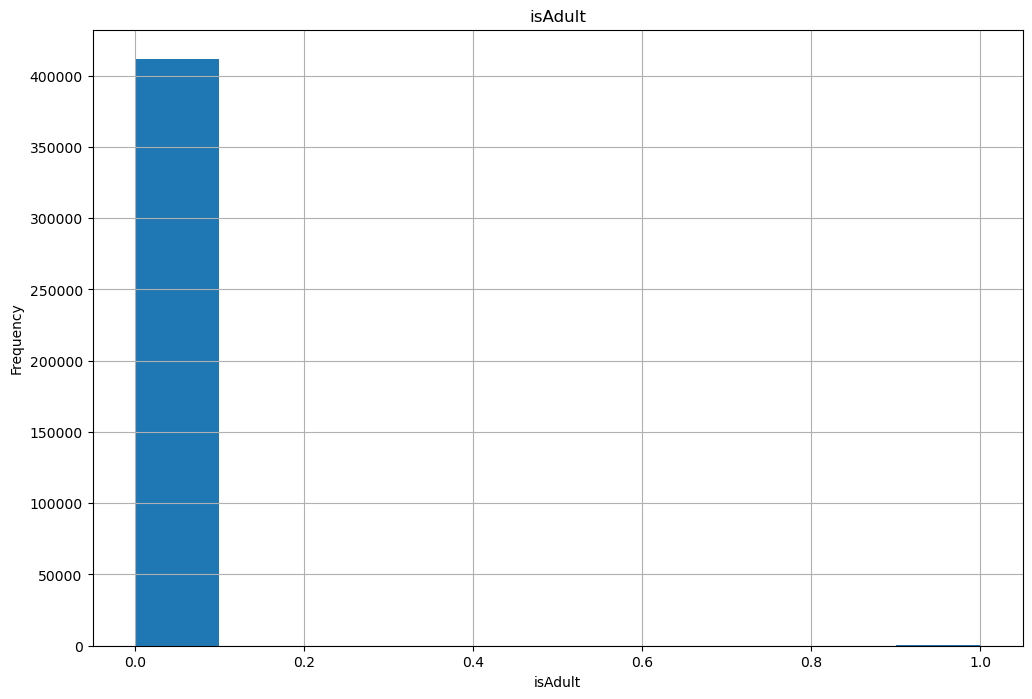

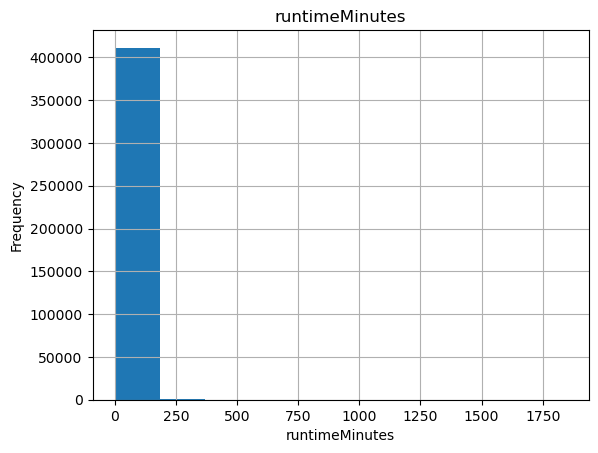

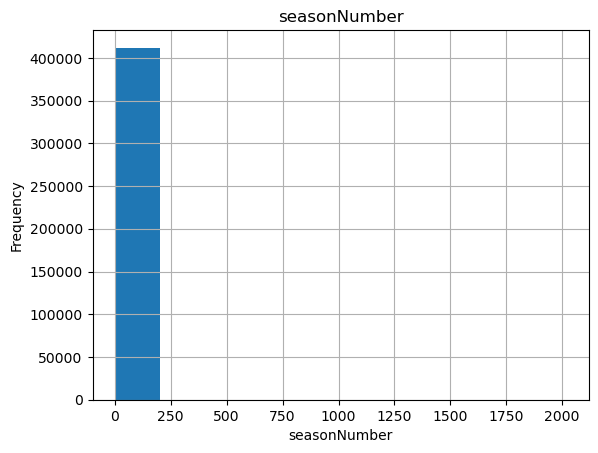

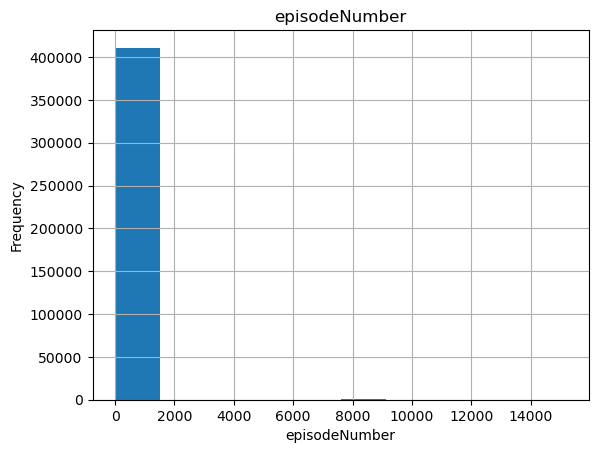

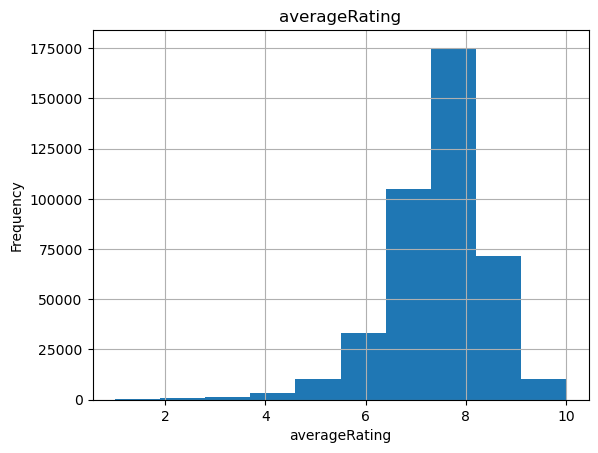

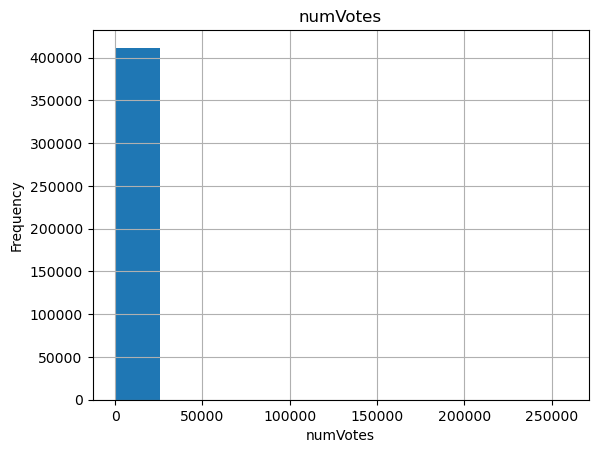

In [67]:
columns_to_plot = ['isAdult', 'runtimeMinutes', 'seasonNumber', 'episodeNumber', 'averageRating', 'numVotes']

plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, 1):
    final_merged_df_cleaned[column].hist() 
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


